<a href="https://colab.research.google.com/github/monahashemiii/QNN/blob/main/DQNN_with_Fault_Injection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Install libs

In [ ]:
!pip install qutip matplotlib scipy

# 1. Feedforward Quantum Neural Networks
This code includes the basic algorithm of the in https://doi.org/10.1038/s41467-020-14454-2 presented QNN learning an unknown unitary operation. See https://github.com/qigitphannover/DeepQuantumNeuralNetworks/blob/master/DQNN_basic.ipynb for generalisations and extensions.

## 1.1 Package-imports, universal definitions and remarks

Import of packages:

In [ ]:
# math related packages
import numpy as np
import scipy as sc
import qutip as qt
# further packages
from time import time
from random import sample
import matplotlib.pyplot as plt
from struct import pack, unpack
import copy

Declaration of qubit kets and density matrices:

In [ ]:
# ket states
qubit0 = qt.basis(2,0)
qubit1 = qt.basis(2,1)
# density matrices
qubit0mat = qubit0 * qubit0.dag() # it is also possible to use ket2dm(qubit0)
qubit1mat = qubit1 * qubit1.dag() # it is also possible to use ket2dm(qubit1)

$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$

### Data conventions

The parameter for the __QNN-Architecture__ $\text{qnnArch}$ describes the structure of a quantum neural network. It is expected to be a 1-dimensional list of natural numbers that which refer to the number of perceptrons in the corresponding layer. E.g. a 2-3-2 network would be given by $\text{qnnArch = [2, 3, 2]}$


The __networks unitaries__ are saved in a 2-dimensional list of Qobjs in a tensored state like

$$\text{unitaries}  = \big[ [\, ],[U_1^1, \dots, U_{m_1}^1], \dots, [U_1^l, \dots, U_{m_l}^l], \dots, [U_1^{out}, \dots, U_{m_{out}}^{out}]\big]$$

$$\text{unitaries[l][j]} = U_{j+1}^l$$

Note that for the perceptron unitaries __no zero-indexing__ is used, since the project was originally initialized in Mathematica.

The __training data__ is saved in $\text{trainingData}$, a 2-dimensional list, where every inner list has exactly two elements like

$$trainingData = \big[ [\text{state}_1,\, \text{unitary} \cdot \text{state}_1], \dots , [\text{state}_N,\, \text{unitary} \cdot \text{state}_N] \big]$$

where $\text{unitary}$ is the __targeted network unitary__. We exemplary build this data with a random unitary. However, in the use case this data would be given.

## 1.2 Helper functions for the QNN-Code

### Partial Trace

The $\text{partialTrace}$ functions assume to be given a quantum object (qutip.Qobj) $\text{obj}$ that is the tensor product of m factors $\{0, 1, \dots, m-1\}$. The functions then calculate and return the __partial trace__ as follows:

$\text{partialTraceRem}$ traces out the factors $$\text{rem} \subsetneq \{0, \dots, m-1\}$$

$\text{partialTraceKeep}$ traces out the factors $$\big( \{0, \dots, m-1\} \setminus \text{keep}\big) \subsetneq \{0, \dots, m-1\}$$

No duplicates in $\text{rem}$ allowed. No values $\geq m$ in $\text{rem}$ or $\text{keep}$ allowed.

In [ ]:
def partialTraceKeep(obj, keep): # generalisation of ptrace(), partial trace via "to-keep" list
    # return partial trace:
    res = obj;
    if len(keep) != len(obj.dims[0]):
        res = obj.ptrace(keep);
    return res;

def partialTraceRem(obj, rem): # partial trace via "to-remove" list
    # prepare keep list
    rem.sort(reverse=True)
    keep = list(range(len(obj.dims[0])))
    for x in rem:
        keep.pop(x)
    res = obj;
    # return partial trace:
    if len(keep) != len(obj.dims[0]):
        res = obj.ptrace(keep);
    return res;


### Basis swap

$\text{swappedOp}$ assumes to be given a quantum object (qutip.Qobj) $\text{obj}$ that is the tensor product of $m$ factors. For

$$\text{obj} = A_0 \otimes \dots \otimes A_i \otimes \dots \otimes A_j \otimes \dots A_{m-1}$$

the function returns

$$A_0 \otimes \dots \otimes A_j \otimes \dots \otimes A_i \otimes \dots A_{m-1}$$

where the factors $i, j \in \{1, \dots, m \}$ are __swapped__.

In [ ]:
def swappedOp(obj, i, j):
    if i==j: return obj
    numberOfQubits = len(obj.dims[0])
    permute = list(range(numberOfQubits))
    permute[i], permute[j] = permute[j], permute[i]
    return obj.permute(permute)

### Further functions

$\text{tensoredId}$ returns $\underbrace{\mathbb{1}_2 \otimes \dots \otimes \mathbb{1}_2}_{N \text{-times}}$

$\text{tensoredQubit0}$ returns $\ket{0 \dots 0}_N \bra{0 \dots 0}$

In [ ]:
def tensoredId(N):
    #Make Identity matrix
    res = qt.qeye(2**N)
    #Make dims list
    dims = [2 for i in range(N)]
    dims = [dims.copy(), dims.copy()]
    res.dims = dims
    #Return
    return res

def tensoredQubit0(N):
    #Make Qubit matrix
    res = qt.fock(2**N).proj() #for some reason ran faster than fock_dm(2**N) in tests
    #Make dims list
    dims = [2 for i in range(N)]
    dims = [dims.copy(), dims.copy()]
    res.dims = dims
    #Return
    return res

$\text{unitariesCopy}$ assumes to be given $\text{unitaries}$ as usual and returns a __deep copy__ of it, meaning a new 2-dimensional list where every element is a copy of the element at the same position in the given 2d-list.

In [ ]:
def unitariesCopy(unitaries): # deep copyof a list of unitaries
    newUnitaries = []
    for layer in unitaries:
        newLayer = []
        for unitary in layer:
            newLayer.append(unitary.copy())
        newUnitaries.append(newLayer)
    return newUnitaries

## 1.3 Random generation of unitaries, training data and networks

### Generation of random unitaries:

$\text{randomQubitUnitary}$ return a unitary $2^{\text{numQubits}} \times 2^{\text{numQubits}}$-matrix as a quantum object (qutip.Qobj) that is the tensor product of $\text{numQubits}$ factors. Before orthogonalization, it's elements are randomly picked out of a normal distribution.

In [ ]:
def randomQubitUnitary(numQubits): # alternatively, use functions rand_unitary and rand_unitary_haar
    dim = 2**numQubits
    #Make unitary matrix
    res = np.random.normal(size=(dim,dim)) + 1j * np.random.normal(size=(dim,dim))
    res = sc.linalg.orth(res)
    res = qt.Qobj(res)
    #Make dims list
    dims = [2 for i in range(numQubits)]
    dims = [dims.copy(), dims.copy()]
    res.dims = dims
    #Return
    return res

### Generation of random training data

$\text{randomQubitState}$ return a unitary $2^{\text{numQubits}}$-vector as a quantum object (qutip.Qobj) that is the tensor product of $\text{numQubits}$ factors. Before normalization, it's elements are randomly picked out of a normal distribution.

$\text{randomTrainingData}$ assumes to be given a unitary quantom object (qutip.Qobj) $\text{unitary}$ that is the tensor product of m factors and returns a list of $N$ training pairs like

$$trainingData = \big[ [\text{state}_1,\, \text{unitary} \cdot \text{state}_1], \dots , [\text{state}_N,\, \text{unitary} \cdot \text{state}_N] \big]$$

In [ ]:
def randomQubitState(numQubits): # alternatively, use functions rand_ket and rand_ket_haar
    dim = 2**numQubits
    #Make normalized state
    res = np.random.normal(size=(dim,1)) + 1j * np.random.normal(size=(dim,1))
    res = (1/sc.linalg.norm(res)) * res
    res = qt.Qobj(res)
    #Make dims list
    dims1 = [2 for i in range(numQubits)]
    dims2 = [1 for i in range(numQubits)]
    dims = [dims1, dims2]
    res.dims = dims
    #Return
    return res

def randomTrainingData(unitary, N): # generating training data based on a unitary
    numQubits = len(unitary.dims[0])
    trainingData=[]
    #Create training data pairs
    for i in range(N):
        t = randomQubitState(numQubits)
        ut = unitary*t
        trainingData.append([t,ut])
    #Return
    return trainingData

### Note regarding Qobj.dims

__Quantum objects in the QuTiP package__ have two properties regarding their sizes: $\text{shape}$ and $\text{dims}$. While $\text{shape}$ denotes the "dimensions of the underlying data matrix", $\text{dims}$ is a "list keeping track of shapes for individual components of a multipartite system" (quoted from the $\text{qutip}$-documentation). The qutip package will only allow operations such as the multiplication of two $\text{Qobj}$ objects $A$ and $B$, if not only their $\text{shape}$s, but also their $\text{dims}$ are compatible. Essentially all $\text{Qobj}$ objects in this work are representing operators or states in an multipartite system of $n$ qubits. As we create such objects with the desired $\text{shape}$, we have to ensure that their $\text{dims}$ are reflective of that, which is why we manually overwrite them to meet this criteria.

### Generation of an initial network

The function $\text{randomNetwork}$ eats a valid QNN architecture $\text{qnnArch}$ and a number of training data pairs, and returns a 4-tuple that __completely describes a trainable quantum-neural-network__ like

$$\big(\text{qnnArch}, \ \text{unitaries} , \ \text{trainingData}, \ \text{networkUnitary} \big)$$

where $\text{networkUnitary}$ being the targeted network unitary (with which the training data was created).

In [ ]:
def randomNetwork(qnnArch, numTrainingPairs):
    assert qnnArch[0]==qnnArch[-1], "Not a valid QNN-Architecture."

    #Create the targeted network unitary and corresponding training data
    networkUnitary = randomQubitUnitary(qnnArch[-1])
    networkTrainingData = randomTrainingData(networkUnitary, numTrainingPairs)

    #Create the initial random perceptron unitaries for the network
    networkUnitaries = [[]]
    for l in range(1, len(qnnArch)):
        numInputQubits = qnnArch[l-1]
        numOutputQubits = qnnArch[l]

        networkUnitaries.append([])
        for j in range(numOutputQubits):
            unitary = randomQubitUnitary(numInputQubits+1)
            if numOutputQubits-1 != 0:
                unitary = qt.tensor(randomQubitUnitary(numInputQubits+1), tensoredId(numOutputQubits-1))
                unitary = swappedOp(unitary, numInputQubits, numInputQubits + j)
            networkUnitaries[l].append(unitary)

    #Return
    return (qnnArch, networkUnitaries, networkTrainingData, networkUnitary)

## 1.4 QNN-Code

### Cost Function

$\text{costFunction}$ assumes to be given $\text{trainingData}$ and $\text{outputStates}$ so that

$$\text{trainingData[x][1]} = \ket{\phi_x^{out}}$$

$$\text{outputStates[x]} = \rho_x^{out}(s)$$

and computes the cost function:

$$C(s) = \frac{1}{N} \sum_{x = 1}^N \bra{\phi_x^{out}} \rho_x^{out}(s) \ket{\phi_x^{out}}$$

In [ ]:
def costFunction(trainingData, outputStates):
    costSum = 0
    for i in range(len(trainingData)):
        # The original line was resulting in a complex number due to
        # the dimensions of the matrices not being compatible for a full trace.
        # Instead, we calculate the expectation value, which is a complex number,
        # and then sum these values.
        # costSum += (trainingData[i][1].dag() * outputStates[i] * trainingData[i][1]).tr() # This line was causing the error

        # Calculate the expectation value using QuTiP's expect function
        costSum += qt.expect(outputStates[i], trainingData[i][1])

    # costSum is now a complex number representing the sum of expectation values.
    # We return the real part of this value divided by the number of data points.
    return costSum.real/len(trainingData) # Return the real part of the cost sum divided by the number of data points

#def costFunction(trainingData, outputStates):
    #costSum = 0
    #for i in range(len(trainingData)):
        #costSum += (trainingData[i][1].dag() * outputStates[i] * trainingData[i][1]).tr()
        ##costSum += trainingData[i][1].dag() * outputStates[i] * trainingData[i][1]
    #return costSum/len(trainingData)
    ##return costSum.tr()/len(trainingData)

### Layer-Channel & Adjoint-Layer-Channel

$\text{makeLayerChannel}$ builds

\begin{align}
\\
\mathcal{E}_s^l(X^{l-1}) & = \text{tr}_{l-1}\bigg( U^l(s) \ \big( X^{l-1} \otimes \ket{0 \dots 0}_l \bra{0 \dots 0} \big) \ U^l(s)^{\dagger} \bigg) \\
& = \text{tr}_{l-1}\bigg( U_{m_l}^l(s) \dots U_1^l(s) \ \big( X^{l-1} \otimes \ket{0 \dots 0}_l \bra{0 \dots 0} \big) \ U_1^l(s)^{\dagger} \dots U_{m_l}^l(s)^{\dagger} \bigg)
\\
\end{align}

and hence describes the __feed-forward process__ for $\text{inputState} = X^{l-1}$, given the QNN architecture, current QNN unitaries and layer number $l$.

In [ ]:
def makeLayerChannel(qnnArch, unitaries, l, inputState):
    numInputQubits = qnnArch[l-1]
    numOutputQubits = qnnArch[l]

    #Tensor input state
    state = qt.tensor(inputState, tensoredQubit0(numOutputQubits))

    #Calculate layer unitary
    layerUni = unitaries[l][0].copy()
    for i in range(1, numOutputQubits):
        layerUni = unitaries[l][i] * layerUni

    #Multiply and tensor out input state
    return partialTraceRem(layerUni * state * layerUni.dag(), list(range(numInputQubits)))

Similarly $\text{makeAdjointLayerChannel}$ builds

\begin{align}
\\
\mathcal{F}_s^l(X^{l}) & = \text{tr}_{l}\bigg( \big( \mathbb{1}_{l-1} \otimes \ket{0 \dots 0}_l \bra{0 \dots 0} \big) \ U^{l}(s)^{\dagger} \ \big( \mathbb{1}_{l-1} \otimes X^l \big) \ U^l(s) \bigg) \\
& = \text{tr}_{l}\bigg( \big( \mathbb{1}_{l-1} \otimes \ket{0 \dots 0}_l \bra{0 \dots 0} \big) \ U_1^l(s)^{\dagger} \dots U_{m_l}^l(s)^{\dagger} \ \big( \mathbb{1}_{l-1} \otimes X^l \big) \ U_{m_l}^l(s) \dots U_1^l(s) \bigg)
\\
\end{align}
and describes the __back-propagation process__.

In [ ]:
def makeAdjointLayerChannel(qnnArch, unitaries, l, outputState):
    numInputQubits = qnnArch[l-1]
    numOutputQubits = qnnArch[l]

    #Prepare needed states
    inputId = tensoredId(numInputQubits)
    state1 = qt.tensor(inputId, tensoredQubit0(numOutputQubits))
    state2 = qt.tensor(inputId, outputState)

    #Calculate layer unitary
    layerUni = unitaries[l][0].copy()
    for i in range(1, numOutputQubits):
        layerUni = unitaries[l][i] * layerUni

    #Multiply and tensor out output state
    return partialTraceKeep(state1 * layerUni.dag() * state2 * layerUni, list(range(numInputQubits)) )

### Feedforward

$\text{feedforward}$ assumes to be given $\text{qnnArch},\, \text{unitaries}$ and $\text{trainingData}$, carries out the feedforward process:

For each element $\big[\, \ket{\phi_x^{in}},\, \ket{\phi_x^{out}} \big]$ in $\text{trainingData}$ do:

- Calculate the network input $\rho_x^{in} = \ket{\phi_x^{in}} \bra{\phi_x^{in}}$

- For every layer $l$ in $\text{qnnArch}$ do:

    - Apply the layer channel $\xi_s^l$ to the output of the previous layer $l-1$

    - Store the result $\rho_x^l(s)$

In [ ]:
def feedforward(qnnArch, unitaries, trainingData):
    storedStates = []
    for x in range(len(trainingData)):
        currentState = trainingData[x][0] * trainingData[x][0].dag()
        layerwiseList = [currentState]
        for l in range(1, len(qnnArch)):
            currentState = makeLayerChannel(qnnArch, unitaries, l, currentState)
            layerwiseList.append(currentState)
        storedStates.append(layerwiseList)
    return storedStates

### Update matrix

$\text{makeUpdateMatrix}$ assumes to be given $\text{qnnArch},\, \text{unitaries},\, \text{trainingData}$ and $\text{storedStates}$ as usual, as well as $\lambda,\, \epsilon \in \mathbb{R}$, and calculates

$$\text{exp}\big( i \, \epsilon \, K_j^l(s) \big)$$

with

$$K_j^l(s) = \frac{2^{n_{a_1, \dots, \beta}} \, i}{2 N \lambda} \sum_x \text{tr}_\text{rest} M_j^l(s)$$

with

$$M_j^l(s) = \big[A_j^l(s), B_j^l(s) \big]$$

with

\begin{align}
A_j^l(s) & = U_j^l(s) \dots U_1^l(s) \, \big( \rho_x^{l-1}(s) \otimes \ket{0 \dots 0}_l \bra{0 \dots 0} \big) \, U_1^l(s)^{\dagger} \dots U_j^l(s)^{\dagger} \\
\\
B_j^l(s) & = U_{j+1}^l(s)^{\dagger} \dots U_{m_l}^l(s)^{\dagger} \, \big( \mathbb{1}_l \otimes \sigma_x^l(s) \big) \, U_{m_l}^l(s) \dots U_{j+1}^l(s)
\end{align}

with

$$\sigma_x^l(s) = \mathcal{F}_s^{l+1} \big( \dots \mathcal{F}_s^{out} \big( \ket{\phi_x^{out}} \bra{\phi_x^{out}} \big) \dots \big).$$

Here the $\text{updateMatrixFirstPart}$ calculates $A_j^l(s)$, $\text{updateMatrixSecondPart}$ calculates $B_j^l(s)$.

$\text{makeUpdateMatrixTensored}$ tensors the result to identities in a way, such that it can be applied to the already tensored perceptron unitaries.
__Note that the backpropagation process is hidden in the part $B_j^l(s)$ of calculating the update matrix.__

In [ ]:
def makeUpdateMatrix(qnnArch, unitaries, trainingData, storedStates, lda, ep, l, j):
    numInputQubits = qnnArch[l-1]

    #Calculate the sum:
    summ = 0
    for x in range(len(trainingData)):
        #Calculate the commutator
        firstPart = updateMatrixFirstPart(qnnArch, unitaries, storedStates, l, j, x)
        secondPart = updateMatrixSecondPart(qnnArch, unitaries, trainingData, l, j, x)
        mat = qt.commutator(firstPart, secondPart)

        #Trace out the rest
        keep = list(range(numInputQubits))
        keep.append(numInputQubits + j)
        mat = partialTraceKeep(mat, keep)

        #Add to sum
        summ = summ + mat

    #Calculate the update matrix from the sum
    summ = (-ep * (2**numInputQubits)/(lda*len(trainingData))) * summ
    return summ.expm()


def updateMatrixFirstPart(qnnArch, unitaries, storedStates, l, j, x):
    numInputQubits = qnnArch[l-1]
    numOutputQubits = qnnArch[l]

    #Tensor input state
    state = qt.tensor(storedStates[x][l-1], tensoredQubit0(numOutputQubits))

    #Calculate needed product unitary
    productUni = unitaries[l][0]
    for i in range(1, j+1):
        productUni = unitaries[l][i] * productUni

    #Multiply
    return productUni * state * productUni.dag()


def updateMatrixSecondPart(qnnArch, unitaries, trainingData, l, j, x):
    numInputQubits = qnnArch[l-1]
    numOutputQubits = qnnArch[l]

    #Calculate sigma state
    state = trainingData[x][1] * trainingData[x][1].dag()
    for i in range(len(qnnArch)-1,l,-1):
        state = makeAdjointLayerChannel(qnnArch, unitaries, i, state)
    #Tensor sigma state
    state = qt.tensor(tensoredId(numInputQubits), state)

    #Calculate needed product unitary
    productUni = tensoredId(numInputQubits + numOutputQubits)
    for i in range(j+1, numOutputQubits):
        productUni = unitaries[l][i] * productUni

    #Multiply
    return productUni.dag() * state * productUni


def makeUpdateMatrixTensored(qnnArch, unitaries, lda, ep, trainingData, storedStates, l, j):
    numInputQubits = qnnArch[l-1]
    numOutputQubits = qnnArch[l]

    res = makeUpdateMatrix(qnnArch, unitaries, lda, ep, trainingData, storedStates, l, j)
    if numOutputQubits-1 != 0:
        res = qt.tensor(res, tensoredId(numOutputQubits-1))
    return swappedOp(res, numInputQubits, numInputQubits + j)

### Training of the Quantum Neural Network

$\text{qnnTraining}$ assumes to be given $\text{qnnArch},\, \text{initialUnitaries}$ and $\text{trainingData}$ as usual, as well as parameters $\lambda,\, \epsilon \in \mathbb{R}$ and $\text{trainingRounds} \in \mathbb{N}$, and __trains the given quantum neural network__:

In [ ]:
def qnnTraining(qnnArch, initialUnitaries, trainingData, lda, ep, trainingRounds, alert=0):

    ### FEEDFORWARD
    #Feedforward for given unitaries
    s = 0
    currentUnitaries = initialUnitaries
    storedStates = feedforward(qnnArch, currentUnitaries, trainingData)

    #Cost calculation for given unitaries
    outputStates = []
    for k in range(len(storedStates)):
        outputStates.append(storedStates[k][-1])
    plotlist = [[s], [costFunction(trainingData, outputStates)]]

    #Optional
    runtime = time()

    unitary_log = []

    #Training of the Quantum Neural Network
    for k in range(trainingRounds):
        if alert>0 and k%alert==0: print("In training round "+str(k))

        ### UPDATING
        newUnitaries = unitariesCopy(currentUnitaries)

        #Loop over layers:
        for l in range(1, len(qnnArch)):
            numInputQubits = qnnArch[l-1]
            numOutputQubits = qnnArch[l]

            #Loop over perceptrons
            for j in range(numOutputQubits):
                newUnitaries[l][j] = (makeUpdateMatrixTensored(qnnArch,currentUnitaries,trainingData,storedStates,lda,ep,l,j)* currentUnitaries[l][j])

        ### FEEDFORWARD
        #Feedforward for given unitaries
        s = s + ep
        currentUnitaries = newUnitaries
        storedStates = feedforward(qnnArch, currentUnitaries, trainingData)

        #Cost calculation for given unitaries
        outputStates = []
        for m in range(len(storedStates)):
            outputStates.append(storedStates[m][-1])
        plotlist[0].append(s)
        plotlist[1].append(costFunction(trainingData, outputStates))
        unitary_log.append(copy.deepcopy(initialUnitaries))  # store after each update

    #Optional
    runtime = time() - runtime
    print("Trained "+str(trainingRounds)+" rounds for a "+str(qnnArch)+" network and "+str(len(trainingData))+" training pairs in "+str(round(runtime, 2))+" seconds")

    #Return
    return [plotlist, currentUnitaries, unitary_log]

###Acuracy

In [ ]:
def accuracyFunction(trainingData, outputStates, threshold=0.99):
    correct = 0
    for i, (inputState, targetState) in enumerate(trainingData):
        pred = outputStates[i]
        fidelity = abs((pred.dag() * targetState)[0,0])**2
        if fidelity >= threshold:
            correct += 1
    return correct / len(trainingData)

def accuracyFunction_fidelity(trainingData, outputStates):
    assert len(trainingData) == len(outputStates)
    fidelities = []
    for i in range(len(trainingData)):
        target = trainingData[i][1]
        pred = outputStates[i]
        fidelity = abs((target.dag() * pred).full()[0, 0]) ** 2
        fidelities.append(fidelity)
    return np.mean(fidelities)

## 1.5 Helper-functions for Tests and Applications

$\text{boundRand}$ gives a formula for the estimate of the cost function, where $D$ is the dimension of the qudit that the network unitary is acting on and $N$ is the number of available training pairs of which the first $n < D$ are chosen for training:

$$C \sim \frac{n}{N} + \frac{N - n}{N \cdot D \cdot (D+1)} \big(D + \text{min}\{n^2 + 1,\, D^2\} \big)$$

In [ ]:
def boundRand(D, N, n):
    return (n/N) + (N-n)/(N*D*(D+1)) * (D + min(n**2+1, D**2))

$\text{subsetTrainingAvg}$ is given the parameters $\text{qnnArch},\, \text{initialUnitaries},\, \text{trainingData},\, \lambda,\, \epsilon$ and $\text{trainingRounds}$ just like $\text{qnnTraining}$. Additionally it recieves  $n, \text{iterations} \in \mathbb{N}$.

$\text{subsetTrainingAvg}$ then does the following $\text{iterations}$-times:

- Choose a subset of $\text{trainingData}$ of size $n$

- Train the given network with said subset

- Calculate the cost function of the resulting network over the whole set of $\text{trainingData}$ and store it

$\text{subsetTrainingAvg}$ ultimately returns the cost averaged over all $\text{iterations}$ results.

In [ ]:
def subsetTrainingAvg(qnnArch, initialUnitaries, trainingData, lda, ep, trainingRounds, iterations, n, alertIt=0):
    costpoints = []

    for i in range(iterations):
        if alertIt>0 and i%alertIt==0: print("n="+str(n)+", i="+str(i))

        #Prepare subset for training
        trainingSubset = sample(trainingData, n)

        #Train with the subset
        learnedUnitaries = qnnTraining(qnnArch, initialUnitaries, trainingSubset, lda, ep, trainingRounds)[1]
        storedStates = feedforward(qnnArch, learnedUnitaries, trainingData)
        outputStates = []
        for k in range(len(storedStates)):
            outputStates.append(storedStates[k][-1])

        #Calculate cost with all training data
        costpoints.append(costFunction(trainingData, outputStates))

    return sum(costpoints)/len(costpoints)

$\text{noisyDataTraining}$ is given the parameters $\text{qnnArch},\, \text{initialUnitaries},\, \lambda,\, \epsilon$ and $\text{trainingRounds}$ just like $\text{qnnTraining}$. Additionally it recieves  $\text{numData}, \text{stepSize} \in \mathbb{N}$ and $\text{trainingData}, \text{noisyData}$.

$\text{noisyDataTraining}$ then does the following ***for i=0; i<numData; i+=stepSize:***

- Create a list $\text{testData}$ by combining a random sample of $\text{trainingData}$ of size $\text{numData}-i$ and a random sample of $\text{noisyData}$ of size $i$

- Train the given network with said $\text{testData}$

- Calculate the cost function of the resulting network over the whole set of $\text{trainingData}$ and store it

$\text{noisyDataTraining}$ ultimately returns the list of costs for all $i$ like

\begin{align}
\big[ & [0, \dots, i, \dots]\\
& [\text{Cost}_0, \dots, \text{Cost}_i, \dots] \big]
\end{align}

In [ ]:
def noisyDataTraining(qnnArch, initialUnitaries, trainingData, noisyData, lda, ep, trainingRounds, numData, stepSize, alertP=0):
    noisyDataPlot = [[], []]

    i = 0
    while i <= numData:
        if alertP>0: print("Currently at "+str(i/numData)+"% noisy data.")

        #Prepare mixed data for traing
        testData1 = sample(trainingData, numData - i)
        testData2 = sample(noisyData, i)
        if i==0: testData = testData1
        elif i==numData: testData = testData2
        else: testData = testData1 + testData2

        #Train with the mixed data
        learnedUnitaries = qnnTraining(qnnArch, initialUnitaries, testData, lda, ep, trainingRounds)[1]
        storedStates = feedforward(qnnArch, learnedUnitaries, trainingData)
        outputStates = []
        for k in range(len(storedStates)):
            outputStates.append(storedStates[k][-1])

        #Calculate cost with the real training data
        noisyDataPlot[0].append(i)
        noisyDataPlot[1].append(costFunction(trainingData, outputStates))

        i += stepSize

    return noisyDataPlot

# 2. Tests and Applications of the QNN-Code

## 2.1 Elementary tests



### 2.1.0 Training a 1-2-1 network

Trained 500 rounds for a [1, 2, 1] network and 10 training pairs in 28.36 seconds
Exceeds cost of 0.99 at training step 26


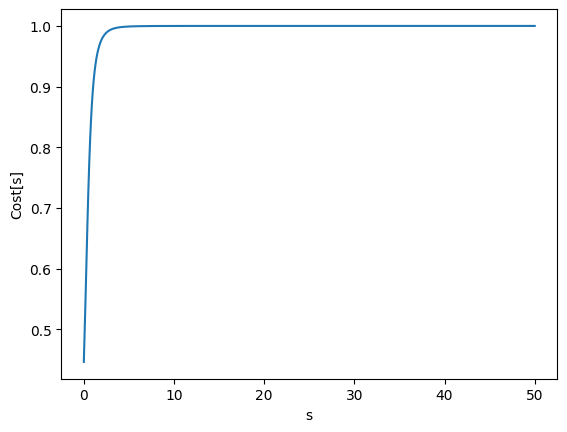

In [ ]:
network121 = randomNetwork([1,2,1], 10)

plotlist121, currentUnitaries, unitary_log = qnnTraining(network121[0], network121[1], network121[2], 1, 0.1, 500)

for i in range(len(plotlist121[1])):
    if plotlist121[1][i] >= 0.99:
        print("Exceeds cost of 0.99 at training step "+str(i))
        break

plt.plot(plotlist121[0], plotlist121[1])
plt.xlabel("s")
plt.ylabel("Cost[s]")
plt.show()

### 2.1.1 Inject fault

In [64]:
network121f = randomNetwork([1,2,1], 10)
qnnArch = network121f[0]
networkUnitaries = network121f[1]
trainingData = network121f[2]
targetUnitary = network121f[3]
Rounds = 500
ep = 0.1

plotlist121, currentUnitaries, unitary_log = qnnTraining(network121f[0], network121f[1], network121f[2], 1, ep, Rounds)

# ---- Fault Definition----
def flip_bit_in_float(val, bit):
    [d] = np.array([val], dtype=np.float32).view(np.uint32)
    d ^= 1 << bit
    return np.array([d], dtype=np.uint32).view(np.float32)[0]

def inject_fault_in_unitary(unitaries, layer, unit, element, bit, real):
    faulty_unitaries = unitaries.copy()
    faulty_unitaries = [layer.copy() if isinstance(layer, list) else layer for layer in unitaries]
    U = faulty_unitaries[layer][unit].full()
    if real == 'real':
        faulty_real = flip_bit_in_float(U[element[0], element[1]].real, bit)
        U[element[0], element[1]] = faulty_real + 1j * U[element[0], element[1]].imag
    else:
        faulty_real = flip_bit_in_float(U[element[0], element[1]].imag, bit)
        U[element[0], element[1]] = U[element[0], element[1]].real + 1j * faulty_real
    faulty_unitaries[layer][unit] = qt.Qobj(U, dims=unitaries[layer][unit].dims)
    return faulty_unitaries

# ---- Fault Injection in Real----
faultyUnitaries_real = inject_fault_in_unitary(currentUnitaries, 1, 0, (0,0), 31, 'real')
faultyUnitaries_real_0 = inject_fault_in_unitary(currentUnitaries, 1, 0, (0,0), 0, 'real')
faultyUnitaries_real_2 = inject_fault_in_unitary(currentUnitaries, 2, 0, (0,0), 31, 'real')
faultyUnitaries_real_30 = inject_fault_in_unitary(currentUnitaries, 2, 0, (0,0), 30, 'real') #less resiliency rank1
faultyUnitaries_real_30_1 = inject_fault_in_unitary(currentUnitaries, 1, 0, (0,0), 30, 'real') #less resiliency rank2

if faultyUnitaries_real == currentUnitaries:
    print("No fault injected in real.")
else:
    print("⚠️ Fault injected in real.")

# ---- Fault Injection in Imag----
faultyUnitaries_imag = inject_fault_in_unitary(currentUnitaries, 1, 0, (0,0), 31, 'Imag')
faultyUnitaries_imag_0 = inject_fault_in_unitary(currentUnitaries, 1, 0, (0,0), 0, 'Imag')
faultyUnitaries_imag_2 = inject_fault_in_unitary(currentUnitaries, 2, 0, (0,0), 31, 'Imag')
faultyUnitaries_imag_20 = inject_fault_in_unitary(currentUnitaries, 2, 0, (0,0), 0, 'Imag')
faultyUnitaries_imag_30 = inject_fault_in_unitary(currentUnitaries, 1, 0, (0,0), 30, 'Imag')

if faultyUnitaries_imag == currentUnitaries:
    print("No fault injected in imag.")
else:
    print("⚠️ Fault injected in imag.")

### 2.1.1 Not injecting faults dynamically over time but just want to compare “before” and “after”:

✅ Cost Before Fault: 1.000000
⚠️ Cost After Fault in real: 0.759492
⚠️ Cost After Fault in real: 1.000000
⚠️ Cost After Fault in real: 0.805841
⚠️ Cost After Fault in real: 8590869697935016623689389328719366521834201093555925341865583843049046278144.000000
⚠️ Cost After Fault in real: 4118489264234008905863565866431019209535229099597712475234498149391068561408.000000
⚠️ Cost After Fault in imag: 0.969662
⚠️ Cost After Fault in imag: 1.000000
⚠️ Cost After Fault in imag: 1.008814
⚠️ Cost After Fault in imag: 1.000000
⚠️ Cost After Fault in imag: 330883529643048826620666419127300940230146483378264678976837571669307424768.000000


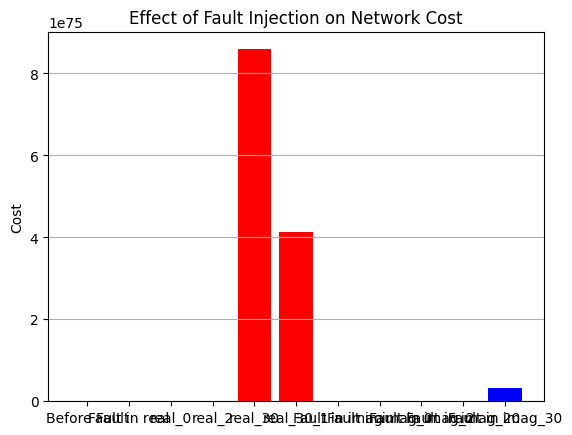

In [65]:
# Cost before fault (final trained model)
final_outputs = []
storedStates = feedforward(qnnArch, currentUnitaries, trainingData)
for state in storedStates:
    final_outputs.append(state[-1])
cost_before = costFunction(trainingData, final_outputs)

# Cost after fault in real
#1
fault_outputs_real = []
storedStates_real = feedforward(qnnArch, faultyUnitaries_real, trainingData)

for state in storedStates_real:
    fault_outputs_real.append(state[-1])
cost_after_real = costFunction(trainingData, fault_outputs_real)
#2
fault_outputs_real = []
storedStates_real_0 = feedforward(qnnArch, faultyUnitaries_real_0, trainingData)

for state in storedStates_real_0:
    fault_outputs_real.append(state[-1])
cost_after_real_0 = costFunction(trainingData, fault_outputs_real)
#3
fault_outputs_real = []
storedStates_real_2 = feedforward(qnnArch, faultyUnitaries_real_2, trainingData)

for state in storedStates_real_2:
    fault_outputs_real.append(state[-1])
cost_after_real_2 = costFunction(trainingData, fault_outputs_real)
#4
fault_outputs_real = []
storedStates_real_30 = feedforward(qnnArch, faultyUnitaries_real_30, trainingData)

for state in storedStates_real_30:
    fault_outputs_real.append(state[-1])
cost_after_real_30 = costFunction(trainingData, fault_outputs_real)
#5
fault_outputs_real = []
storedStates_real_30_1 = feedforward(qnnArch, faultyUnitaries_real_30_1, trainingData)

for state in storedStates_real_30_1:
    fault_outputs_real.append(state[-1])
cost_after_real_30_1 = costFunction(trainingData, fault_outputs_real)
# Cost after fault in imag
#1
fault_outputs_imag = []
storedStates_imag = feedforward(qnnArch, faultyUnitaries_imag, trainingData)

for state in storedStates_imag:
    fault_outputs_imag.append(state[-1])
cost_after_imag = costFunction(trainingData, fault_outputs_imag)
#2
fault_outputs_imag = []
storedStates_imag_0 = feedforward(qnnArch, faultyUnitaries_imag_0, trainingData)

for state in storedStates_imag_0:
    fault_outputs_imag.append(state[-1])
cost_after_imag_0 = costFunction(trainingData, fault_outputs_imag)
#3
fault_outputs_imag = []
storedStates_imag_2 = feedforward(qnnArch, faultyUnitaries_imag_2, trainingData)

for state in storedStates_imag_2:
    fault_outputs_imag.append(state[-1])
cost_after_imag_2 = costFunction(trainingData, fault_outputs_imag)
#4
fault_outputs_imag = []
storedStates_imag_20 = feedforward(qnnArch, faultyUnitaries_imag_20, trainingData)

for state in storedStates_imag_20:
    fault_outputs_imag.append(state[-1])
cost_after_imag_20 = costFunction(trainingData, fault_outputs_imag)
#5
fault_outputs_imag = []
storedStates_imag_30 = feedforward(qnnArch, faultyUnitaries_imag_30, trainingData)

for state in storedStates_imag_30:
    fault_outputs_imag.append(state[-1])
cost_after_imag_30 = costFunction(trainingData, fault_outputs_imag)

# Print comparison
print(f"✅ Cost Before Fault: {cost_before:.6f}")
print(f"⚠️ Cost After Fault in real: {cost_after_real:.6f}")
print(f"⚠️ Cost After Fault in real: {cost_after_real_0:.6f}")
print(f"⚠️ Cost After Fault in real: {cost_after_real_2:.6f}")
print(f"⚠️ Cost After Fault in real: {cost_after_real_30:.6f}")
print(f"⚠️ Cost After Fault in real: {cost_after_real_30_1:.6f}")
print(f"⚠️ Cost After Fault in imag: {cost_after_imag:.6f}")
print(f"⚠️ Cost After Fault in imag: {cost_after_imag_0:.6f}")
print(f"⚠️ Cost After Fault in imag: {cost_after_imag_2:.6f}")
print(f"⚠️ Cost After Fault in imag: {cost_after_imag_20:.6f}")
print(f"⚠️ Cost After Fault in imag: {cost_after_imag_30:.6f}")

# Optional: simple bar plot
plt.bar(['Before Fault', 'Fault in real','real_0','real_2', 'real_30','real_30_1', 'Fault in imag', 'Fault in imag_0', 'Fault in imag_2', 'Fault in imag_20', 'Fault in imag_30'], [cost_before, cost_after_real, cost_after_real_0, cost_after_real_2, cost_after_real_30, cost_after_real_30_1, cost_after_imag, cost_after_imag_0, cost_after_imag_2, cost_after_imag_20, cost_after_imag_30], color=['green', 'red', 'red', 'red', 'red', 'red', 'blue', 'blue', 'blue', 'blue', 'blue'])
plt.ylabel("Cost")
plt.title("Effect of Fault Injection on Network Cost")
plt.grid(True, axis='y')
plt.show()

### 2.1.2 Sweep Over Multiple Faults (to see how cost changes by flipping different bits):

✅ Cost Before Fault: 1.000000
⚠️ Cost After Fault at Bit 0.000000: 1.000000
⚠️ Cost After Fault at Bit 1.000000: 1.000000
⚠️ Cost After Fault at Bit 2.000000: 1.000000
⚠️ Cost After Fault at Bit 3.000000: 1.000000
⚠️ Cost After Fault at Bit 4.000000: 1.000000
⚠️ Cost After Fault at Bit 5.000000: 1.000000
⚠️ Cost After Fault at Bit 6.000000: 0.999999
⚠️ Cost After Fault at Bit 7.000000: 0.999998
⚠️ Cost After Fault at Bit 8.000000: 1.000004
⚠️ Cost After Fault at Bit 9.000000: 1.000008
⚠️ Cost After Fault at Bit 10.000000: 0.999984
⚠️ Cost After Fault at Bit 11.000000: 1.000031
⚠️ Cost After Fault at Bit 12.000000: 0.999937
⚠️ Cost After Fault at Bit 13.000000: 1.000125
⚠️ Cost After Fault at Bit 14.000000: 1.000250
⚠️ Cost After Fault at Bit 15.000000: 1.000501
⚠️ Cost After Fault at Bit 16.000000: 0.998999
⚠️ Cost After Fault at Bit 17.000000: 0.998001
⚠️ Cost After Fault at Bit 18.000000: 0.996009
⚠️ Cost After Fault at Bit 19.000000: 0.992049
⚠️ Cost After Fault at Bit 20.000000: 0.

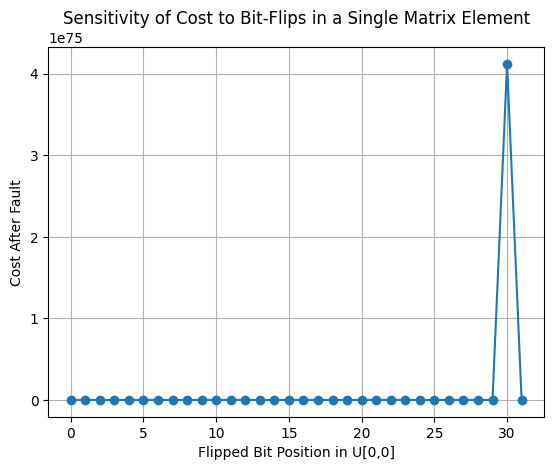

In [60]:
plot_bits = []
plot_costs = []

# Cost before fault (final trained model)
final_outputs = []
storedStates = feedforward(qnnArch, currentUnitaries, trainingData)
for state in storedStates:
    final_outputs.append(state[-1])
cost_before = costFunction(trainingData, final_outputs)
print(f"✅ Cost Before Fault: {cost_before:.6f}")

for bit in range(32):  # flip bit 0 to 31
    faultyUnitaries = inject_fault_in_unitary(currentUnitaries, 1, 0, (0,0), bit, 'real')

    fault_outputs = []
    storedStates = feedforward(qnnArch, faultyUnitaries, trainingData)
    for state in storedStates:
        fault_outputs.append(state[-1])
    cost = costFunction(trainingData, fault_outputs)

    plot_bits.append(bit)
    plot_costs.append(cost)
    print(f"⚠️ Cost After Fault at Bit {bit:.6f}: {cost:.6f}")


plt.plot(plot_bits, plot_costs, marker='o')
plt.xlabel("Flipped Bit Position in U[0,0]")
plt.ylabel("Cost After Fault")
plt.title("Sensitivity of Cost to Bit-Flips in a Single Matrix Element")
plt.grid(True)
plt.show()

### 2.1.3 Simple Accuracy Comparison – Before vs. After Fault

Input:
trainingData[i][0] (state_in)

Target:
trainingData[i][1] (state_out_target = U.state_in)

Predicted:
outputStates[i] from feedforward (...)

Accuracy:
Average fidelity over samples



✅ Accuracy Before Fault: 0.00%
✅ Accuracy Before Fault: 56.81%
⚠️ Accuracy After Fault: 0.00%
⚠️ Accuracy After Fault: 52.57%
Accuracy Drop:         0.00%
Accuracy Drop:         4.24%


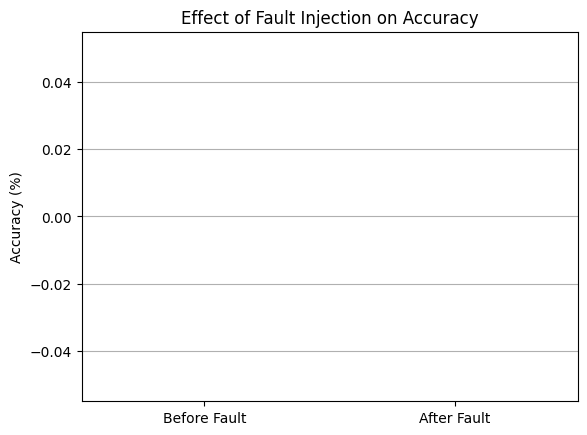

In [ ]:
# ---- Output Before Fault ----
storedStates = feedforward(qnnArch, currentUnitaries, trainingData)
outputStates_before = [state[-1] for state in storedStates]
acc_before = accuracyFunction(trainingData, outputStates_before)
acc_before_new = accuracyFunction_fidelity(trainingData, outputStates_before)
print(f"✅ Accuracy Before Fault: {acc_before*100:.2f}%")
print(f"✅ Accuracy Before Fault: {acc_before_new*100:.2f}%")

# ---- Inject Fault and Evaluate ----
faultyUnitaries = inject_fault_in_unitary(currentUnitaries, 1, 0, (0, 0), 31)
storedStates = feedforward(qnnArch, faultyUnitaries, trainingData)
outputStates_after = [state[-1] for state in storedStates]
acc_after = accuracyFunction(trainingData, outputStates_after)
print(f"⚠️ Accuracy After Fault: {acc_after*100:.2f}%")
acc_after_new = accuracyFunction_fidelity(trainingData, outputStates_after)
print(f"⚠️ Accuracy After Fault: {acc_after_new*100:.2f}%")

print(f"Accuracy Drop:         {(acc_before - acc_after) * 100:.2f}%")
print(f"Accuracy Drop:         {(acc_before_new - acc_after_new) * 100:.2f}%")
# ---- Plot Bar Chart ----
plt.bar(['Before Fault', 'After Fault'], [acc_before*100, acc_after*100], color=['green', 'red'])
plt.ylabel("Accuracy (%)")
plt.title("Effect of Fault Injection on Accuracy")
plt.grid(axis='y')
plt.show()

### 2.1.4 Bit-Flip Sweep – Sensitivity per Bit

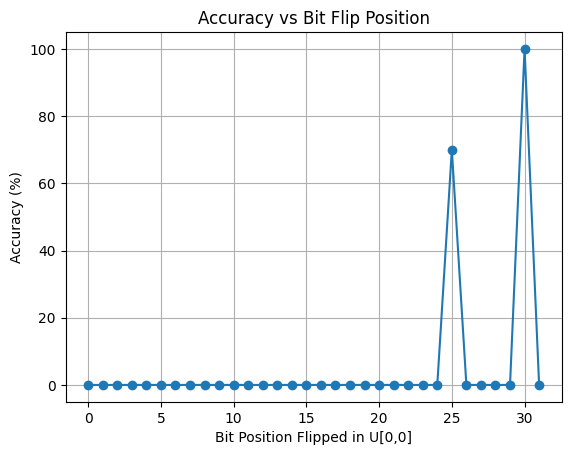

In [ ]:
bit_positions = range(32)
accuracies = []

for bit in bit_positions:
    faultyUnitaries = inject_fault_in_unitary(currentUnitaries, 1, 0, (0, 0), bit)
    storedStates = feedforward(qnnArch, faultyUnitaries, trainingData)
    outputStates = [state[-1] for state in storedStates]
    acc = accuracyFunction(trainingData, outputStates)
    accuracies.append(acc * 100)

plt.plot(bit_positions, accuracies, marker='o')
plt.xlabel("Bit Position Flipped in U[0,0]")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs Bit Flip Position")
plt.grid(True)
plt.show()

### 2.1.5 Sweep Across Layers and Matrix Elements

In [ ]:
layer_range = range(1, len(currentUnitaries))  # skip layer 0
results = []

for layer in layer_range:
    for unit in range(len(currentUnitaries[layer])):
        U = currentUnitaries[layer][unit].full()
        for row in range(U.shape[0]):
            for col in range(U.shape[1]):
                faultyUnitaries = inject_fault_in_unitary(currentUnitaries, layer, unit, (row, col), 31)  # Flip LSB
                storedStates = feedforward(qnnArch, faultyUnitaries, trainingData)
                outputStates = [state[-1] for state in storedStates]
                acc = accuracyFunction(trainingData, outputStates)
                results.append((layer, unit, (row, col), acc * 100))

# Display as table
for layer, unit, (r, c), acc in results:
    print(f"Layer {layer}, Unit {unit}, Element ({r},{c}) -> Accuracy: {acc:.2f}%")

Layer 1, Unit 0, Element (0,0) -> Accuracy: 0.00%
Layer 1, Unit 0, Element (0,1) -> Accuracy: 0.00%
Layer 1, Unit 0, Element (0,2) -> Accuracy: 0.00%
Layer 1, Unit 0, Element (0,3) -> Accuracy: 0.00%
Layer 1, Unit 0, Element (0,4) -> Accuracy: 0.00%
Layer 1, Unit 0, Element (0,5) -> Accuracy: 0.00%
Layer 1, Unit 0, Element (0,6) -> Accuracy: 0.00%
Layer 1, Unit 0, Element (0,7) -> Accuracy: 0.00%
Layer 1, Unit 0, Element (1,0) -> Accuracy: 0.00%
Layer 1, Unit 0, Element (1,1) -> Accuracy: 0.00%
Layer 1, Unit 0, Element (1,2) -> Accuracy: 0.00%
Layer 1, Unit 0, Element (1,3) -> Accuracy: 0.00%
Layer 1, Unit 0, Element (1,4) -> Accuracy: 0.00%
Layer 1, Unit 0, Element (1,5) -> Accuracy: 0.00%
Layer 1, Unit 0, Element (1,6) -> Accuracy: 0.00%
Layer 1, Unit 0, Element (1,7) -> Accuracy: 0.00%
Layer 1, Unit 0, Element (2,0) -> Accuracy: 0.00%
Layer 1, Unit 0, Element (2,1) -> Accuracy: 0.00%
Layer 1, Unit 0, Element (2,2) -> Accuracy: 0.00%
Layer 1, Unit 0, Element (2,3) -> Accuracy: 0.00%


###2.1.6 Heat map

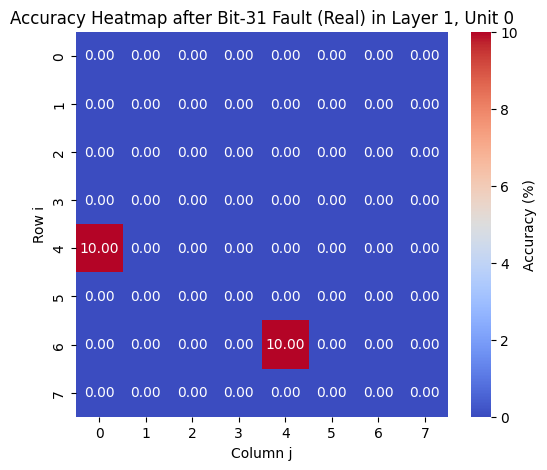

In [ ]:
import seaborn as sns

def plot_accuracy_heatmap(unitaries, layer=1, unit=0, bit=31, inject_real=True):
    U = currentUnitaries[layer][unit].full()
    shape = U.shape
    heatmap_data = np.zeros(shape)

    for i in range(shape[0]):
        for j in range(shape[1]):
            val = U[i, j].real if inject_real else U[i, j].imag
            faulty_val = flip_bit_in_float(val, bit)
            if inject_real:
                U[i, j] = faulty_val + 1j * U[i, j].imag
            else:
                U[i, j] = U[i, j].real + 1j * faulty_val

            faulty_unitaries = currentUnitaries.copy()
            faulty_unitaries = [layer.copy() if isinstance(layer, list) else layer for layer in currentUnitaries]
            faulty_unitaries[layer][unit] = qt.Qobj(U, dims=currentUnitaries[layer][unit].dims)

            outputStates = [state[-1] for state in feedforward(qnnArch, faulty_unitaries, trainingData)]
            acc = accuracyFunction(trainingData, outputStates)

            heatmap_data[i, j] = acc * 100  # Save accuracy
            U = currentUnitaries[layer][unit].full()  # Restore original U

    plt.figure(figsize=(6,5))
    sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'Accuracy (%)'})
    plt.title(f"Accuracy Heatmap after Bit-{bit} Fault ({'Real' if inject_real else 'Imag'}) in Layer {layer}, Unit {unit}")
    plt.xlabel("Column j")
    plt.ylabel("Row i")
    plt.show()

plot_accuracy_heatmap(currentUnitaries, layer=1, unit=0, bit=31, inject_real=True)

###2.1.7 Try Other Bit Positions (0–31)

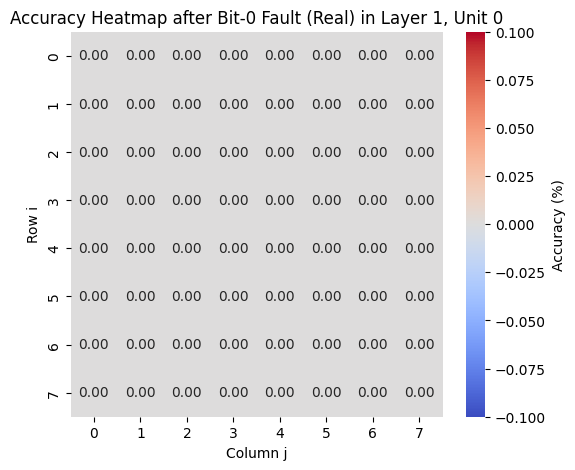

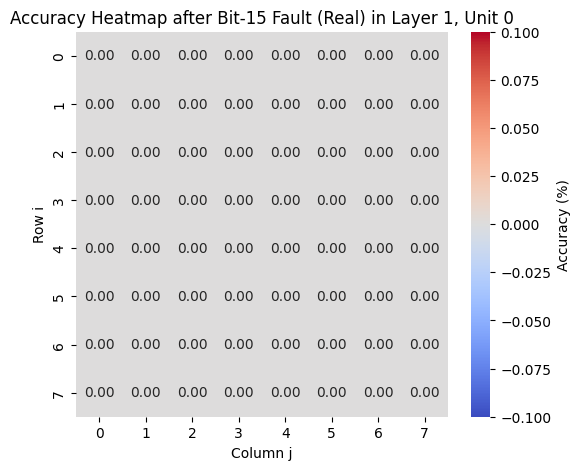

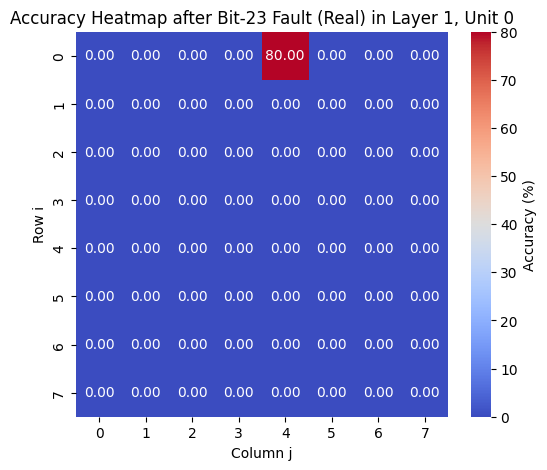

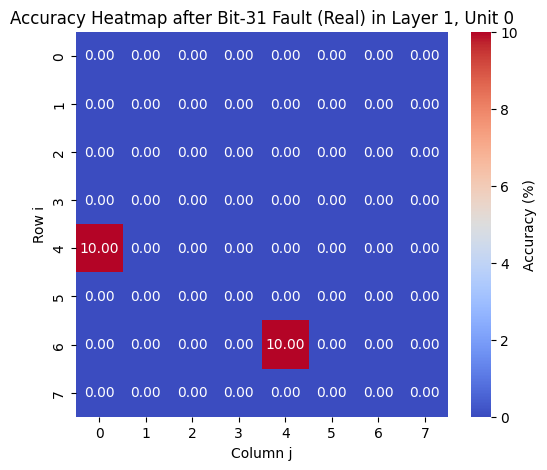

In [ ]:
for b in [0, 15, 23, 31]:  # MSB to LSB samples
    plot_accuracy_heatmap(currentUnitaries, layer=1, unit=0, bit=b, inject_real=True)

###2.1.8 Inject in Both Real and Imaginary Parts

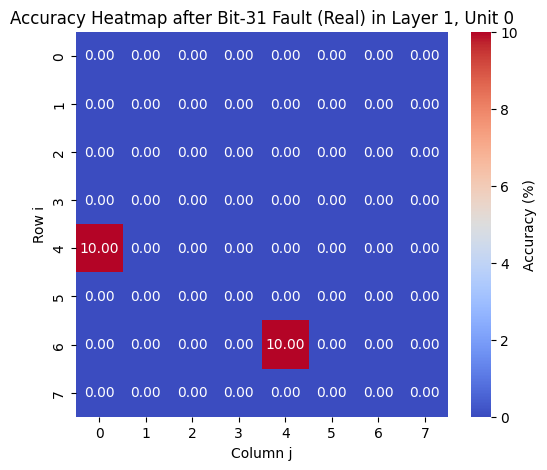

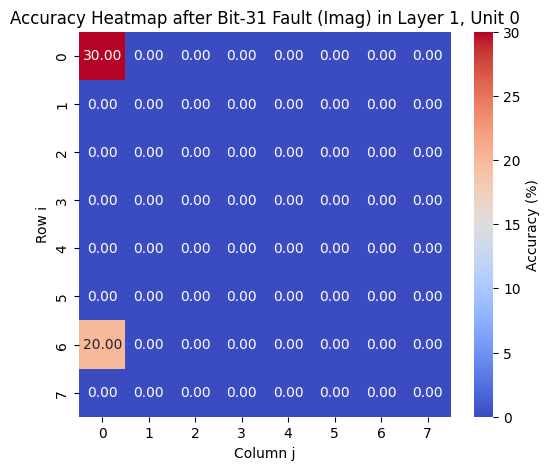

In [ ]:
for part in ['real', 'imag']:
    plot_accuracy_heatmap(currentUnitaries, layer=1, unit=0, bit=31, inject_real=(part == 'real'))

###2.1.9 3D Surface Plot for Bit Position × Matrix Index

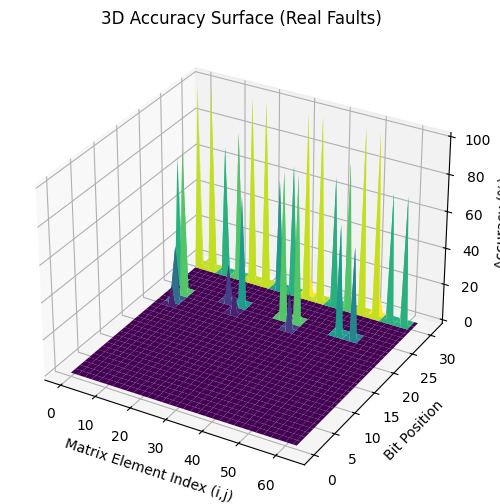

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_surface_accuracy(unitaries, layer=1, unit=0, inject_real=True):
    U = currentUnitaries[layer][unit].full()
    num_bits = 32
    flat_len = U.shape[0] * U.shape[1]
    accuracy_matrix = np.zeros((num_bits, flat_len))

    for bit in range(num_bits):
        for idx in range(flat_len):
            i, j = divmod(idx, U.shape[1])
            val = U[i, j].real if inject_real else U[i, j].imag
            faulty_val = flip_bit_in_float(val, bit)

            if inject_real:
                U[i, j] = faulty_val + 1j * U[i, j].imag
            else:
                U[i, j] = U[i, j].real + 1j * faulty_val

            faulty_unitaries = [layer.copy() if isinstance(layer, list) else layer for layer in currentUnitaries]
            faulty_unitaries[layer][unit] = qt.Qobj(U, dims=currentUnitaries[layer][unit].dims)
            outputStates = [state[-1] for state in feedforward(qnnArch, faulty_unitaries, trainingData)]
            acc = accuracyFunction(trainingData, outputStates)
            accuracy_matrix[bit, idx] = acc * 100
            U = currentUnitaries[layer][unit].full()  # restore

    X, Y = np.meshgrid(range(flat_len), range(num_bits))

    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, accuracy_matrix, cmap='viridis')
    ax.set_xlabel("Matrix Element Index (i,j)")
    ax.set_ylabel("Bit Position")
    ax.set_zlabel("Accuracy (%)")
    ax.set_title(f"3D Accuracy Surface ({'Real' if inject_real else 'Imag'} Faults)")
    plt.show()

plot_3d_surface_accuracy(currentUnitaries, layer=1, unit=0, inject_real=True)

# 3. Fault Analysis

## 3.1 Qnn Fault Analysis

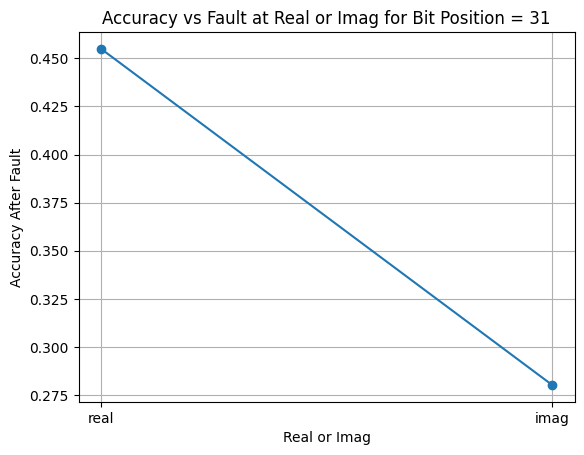

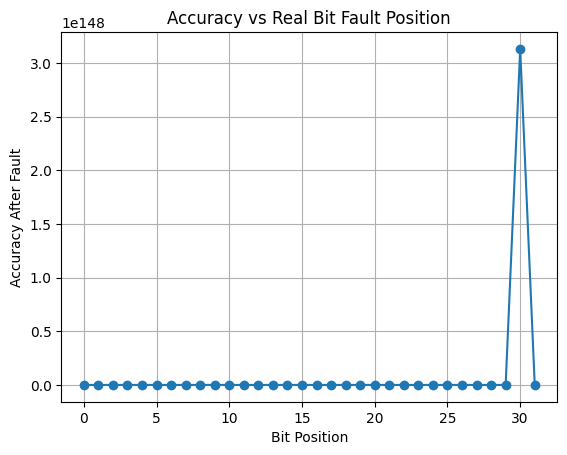

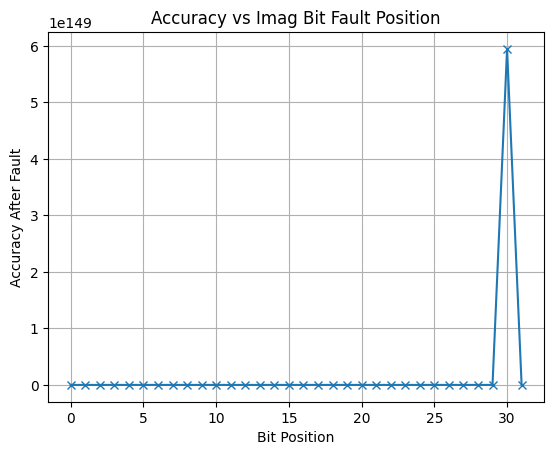

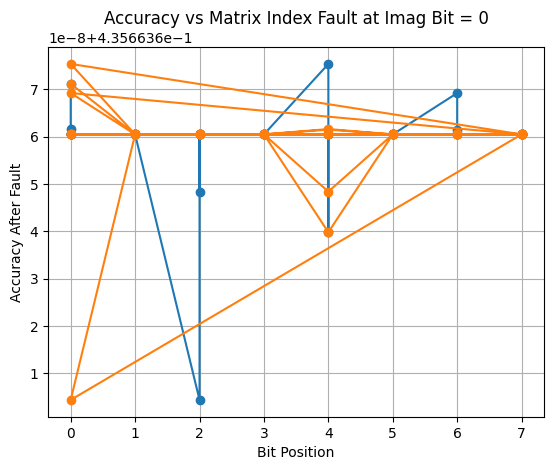

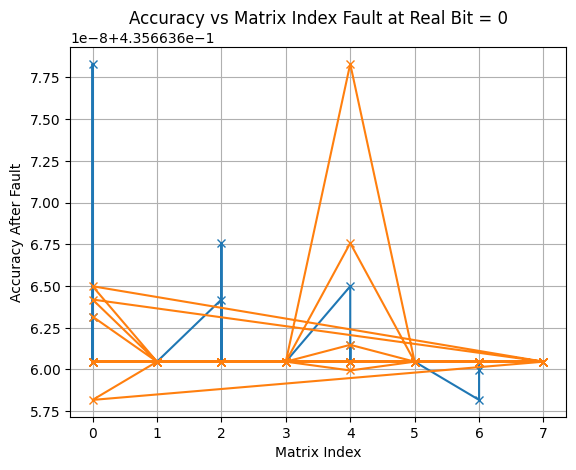

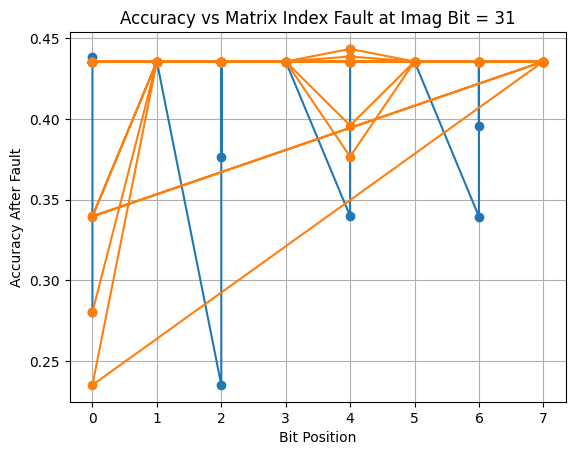

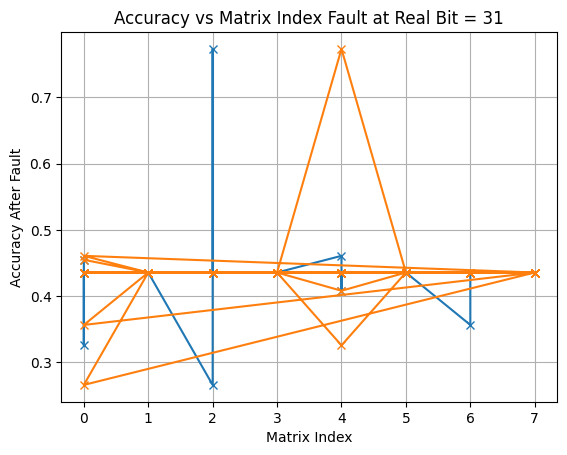

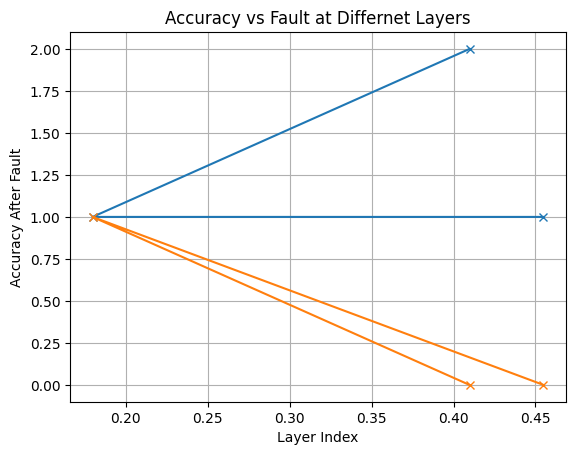

In [ ]:
# --- Step 1: Bit Flip Fault Injection ---
def flip_bit_in_float(val, bit):
    [d] = np.array([val], dtype=np.float32).view(np.uint32)
    d ^= 1 << bit
    return np.array([d], dtype=np.uint32).view(np.float32)[0]

# --- Step 2: Fault Injection ---
def inject_fault(unitaries, layer, unit, row, col, bit, part):
    faulty = [layer.copy() if isinstance(layer, list) else layer for layer in unitaries]
    U = faulty[layer][unit].full()
    if part == 'real':
        faulty_val = flip_bit_in_float(U[row, col].real, bit) + 1j * U[row, col].imag
    else:
        faulty_val = U[row, col].real + 1j * flip_bit_in_float(U[row, col].imag, bit)
    U[row, col] = faulty_val
    faulty[layer][unit] = qt.Qobj(U, dims=unitaries[layer][unit].dims)
    return faulty

# --- Sweep 1: Real vs Imag Part ---
def sweep_real_vs_imag(qnnArch, unitaries, trainingData, layer, unit, i, j, bit):
    results = {}
    for part in ['real', 'imag']:
        #unitaries, layer, unit, row, col, bit, part
        faulted = inject_fault(unitaries, layer, unit, i, j, bit, part=part)
        outputStates = [feedforward(qnnArch, faulted, [pair])[0][-1] for pair in trainingData]
        acc = accuracyFunction_fidelity(trainingData, outputStates)
        results[part] = acc
    return results

# --- Sweep 2: Across Bit Positions ---
def sweep_bit_positions(qnnArch, unitaries, trainingData, layer, unit, i, j, part):
    results = []
    for bit in range(32):
        #unitaries, layer, unit, row, col, bit, part
        faulted = inject_fault(unitaries, layer, unit, i, j, bit, part)
        outputStates = [feedforward(qnnArch, faulted, [pair])[0][-1] for pair in trainingData]
        acc = accuracyFunction_fidelity(trainingData, outputStates)
        results.append((bit, acc))
    return results

# --- Sweep 3: Across Matrix Indices ---
def sweep_matrix_indices(qnnArch, unitaries, trainingData, layer, unit, bit, part):
    dim = unitaries[layer][unit].shape[0]
    results = []
    for i in range(dim):
        for j in range(dim):
            #unitaries, layer, unit, row, col, bit, part
            faulted = inject_fault(unitaries, layer, unit, i, j, bit, part)
            outputStates = [feedforward(qnnArch, faulted, [pair])[0][-1] for pair in trainingData]
            acc = accuracyFunction_fidelity(trainingData, outputStates)
            results.append(((i, j), acc))
    return results

# --- Sweep 4: Across Layers ---
def sweep_layers(qnnArch, unitaries, trainingData, i, j, bit, part):
    results = []
    for l in range(1, len(qnnArch)):
        for u in range(qnnArch[l]):
            #unitaries, layer, unit, row, col, bit, part
            faulted = inject_fault(unitaries, l, u, i, j, bit, part)
            outputStates = [feedforward(qnnArch, faulted, [pair])[0][-1] for pair in trainingData]
            acc = accuracyFunction_fidelity(trainingData, outputStates)
            results.append(((l, u), acc))
    return results

# --- Heatmap/3D Plot (example for matrix indices) ---
def plot_heatmap(data, title="Heatmap", xlabel="i", ylabel="j"):
    size = int(np.sqrt(len(data)))
    matrix = np.zeros((size, size))
    for (i, j), acc in data:
        matrix[i, j] = acc
    plt.imshow(matrix, cmap='viridis', interpolation='nearest')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.colorbar(label="Accuracy")
    plt.show()

# --- All Sweeps ---
def sweep_fault_injection_driver(qnnArch, trainedUnitaries, trainingData):
    """
    Perform full fault injection analysis:
    - Sweep over layers
    - Sweep over matrix indices
    - Sweep over bit positions
    - Sweep real vs imaginary
    """
    print("🔍 Starting Sweep: Real vs Imaginary")
    real_imag_results = sweep_real_vs_imag(qnnArch, trainedUnitaries, trainingData, 1, 0, 0, 0, bit=31)

    print("🔍 Starting Sweep: Bit Positions in Real")
    bit_results_real = sweep_bit_positions(qnnArch, trainedUnitaries, trainingData, layer=1, unit=0, i=0, j=0, part='real')
    print("🔍 Starting Sweep: Bit Positions in Imag")
    bit_results_imag = sweep_bit_positions(qnnArch, trainedUnitaries, trainingData, layer=1, unit=0, i=0, j=0, part='imag')

    print("🔍 Starting Sweep: Matrix Indices in bit=31 Real")
    matrix_results_real31 = sweep_matrix_indices(qnnArch, trainedUnitaries, trainingData, layer=1, unit=0, bit = 31, part='real')
    print("🔍 Starting Sweep: Matrix Indices in bit=31 Imag")
    matrix_results_imag31 = sweep_matrix_indices(qnnArch, trainedUnitaries, trainingData, layer=1, unit=0, bit = 31, part='imag')

    print("🔍 Starting Sweep: Matrix Indices in bit=0 Real")
    matrix_results_real0 = sweep_matrix_indices(qnnArch, trainedUnitaries, trainingData, layer=1, unit=0, bit = 0, part='real')
    print("🔍 Starting Sweep: Matrix Indices in bit=0 Imag")
    matrix_results_imag0 = sweep_matrix_indices(qnnArch, trainedUnitaries, trainingData, layer=1, unit=0, bit = 0, part='imag')

    print("🔍 Starting Sweep: Layers")
    layer_results = sweep_layers(qnnArch, trainedUnitaries, trainingData, 0, 0, 31, 'real')

    print("✅ Fault Injection Sweeps Completed.")

    return {
        "layer_sweep": layer_results,
        "matrix_index_sweep_real31": matrix_results_real31,
        "matrix_index_sweep_imag31": matrix_results_imag31,
        "matrix_index_sweep_real0": matrix_results_real0,
        "matrix_index_sweep_imag0": matrix_results_imag0,
        "bit_sweep_real": bit_results_real,
        "bit_sweep_imag": bit_results_imag,
        "real_vs_imag_sweep": real_imag_results
    }

# -------------------- Usage --------------------
network121f = randomNetwork([1,2,1], 10)
qnnArch = network121f[0]
networkUnitaries = network121f[1]
trainingData = network121f[2]
targetUnitary = network121f[3]
Rounds = 500
ep = 0.1

plotlist121, currentUnitaries, unitary_log = qnnTraining(network121f[0], network121f[1], network121f[2], 1, ep, Rounds)

results = sweep_fault_injection_driver(qnnArch, currentUnitaries, trainingData)
#bit_positions = results['bit_sweep']['bit_positions']
#accuracies = results['bit_sweep']['accuracies']

# -------------------- 1 --------------------
bit_positions = list(results['real_vs_imag_sweep'].keys()) # Get the keys ('real', 'imag')
accuracies = list(results['real_vs_imag_sweep'].values()) # Get the corresponding accuracy values

plt.plot(bit_positions, accuracies, marker='o')
plt.title("Accuracy vs Fault at Real or Imag for Bit Position = 31")
plt.xlabel("Real or Imag")
plt.ylabel("Accuracy After Fault")
plt.grid(True)
plt.show()

# -------------------- 2 --------------------
bit_positions_real = [bit for bit, acc in results['bit_sweep_real']]
accuracies_real = [acc for bit, acc in results['bit_sweep_real']]

plt.plot(bit_positions_real, accuracies_real, marker='o')
plt.title("Accuracy vs Real Bit Fault Position")
plt.xlabel("Bit Position")
plt.ylabel("Accuracy After Fault")
plt.grid(True)
plt.show()

# -------------------- 3 --------------------
bit_positions_imag = [bit for bit, acc in results['bit_sweep_imag']]
accuracies_imag = [acc for bit, acc in results['bit_sweep_imag']]

plt.plot(bit_positions_imag, accuracies_imag, marker='x')
plt.title("Accuracy vs Imag Bit Fault Position")
plt.xlabel("Bit Position")
plt.ylabel("Accuracy After Fault")
plt.grid(True)
plt.show()

# -------------------- 4 --------------------
MX_positions_imag = [bit for bit, acc in results['matrix_index_sweep_imag0']]
accuracies_MX_imag = [acc for bit, acc in results['matrix_index_sweep_imag0']]

plt.plot(MX_positions_imag, accuracies_MX_imag, marker='o')
plt.title("Accuracy vs Matrix Index Fault at Imag Bit = 0")
plt.xlabel("Bit Position")
plt.ylabel("Accuracy After Fault")
plt.grid(True)
plt.show()

# -------------------- 5 --------------------
MX_positions_real = [bit for bit, acc in results['matrix_index_sweep_real0']]
accuracies_MX_real = [acc for bit, acc in results['matrix_index_sweep_real0']]

plt.plot(MX_positions_real, accuracies_MX_real, marker='x')
plt.title("Accuracy vs Matrix Index Fault at Real Bit = 0")
plt.xlabel("Matrix Index")
plt.ylabel("Accuracy After Fault")
plt.grid(True)
plt.show()

# -------------------- 6 --------------------
MX_positions_imag_31 = [bit for bit, acc in results['matrix_index_sweep_imag31']]
accuracies_MX_imag_31 = [acc for bit, acc in results['matrix_index_sweep_imag31']]

plt.plot(MX_positions_imag_31, accuracies_MX_imag_31, marker='o')
plt.title("Accuracy vs Matrix Index Fault at Imag Bit = 31")
plt.xlabel("Bit Position")
plt.ylabel("Accuracy After Fault")
plt.grid(True)
plt.show()

# -------------------- 7 --------------------
MX_positions_real_31 = [bit for bit, acc in results['matrix_index_sweep_real31']]
accuracies_MX_real_31 = [acc for bit, acc in results['matrix_index_sweep_real31']]

plt.plot(MX_positions_real_31, accuracies_MX_real_31, marker='x')
plt.title("Accuracy vs Matrix Index Fault at Real Bit = 31")
plt.xlabel("Matrix Index")
plt.ylabel("Accuracy After Fault")
plt.grid(True)
plt.show()

# -------------------- 8 --------------------
layer_positions = [bit for bit, acc in results['layer_sweep']]
accuracies_layer = [acc for bit, acc in results['layer_sweep']]

plt.plot(accuracies_layer, layer_positions, marker='x')
plt.title("Accuracy vs Fault at Differnet Layers")
plt.xlabel("Layer Index")
plt.ylabel("Accuracy After Fault")
plt.grid(True)
plt.show()


## 3.2 Inject Fault at Fixed Location After Training
Inject only once (e.g., MSB of real part at layer 1, unit 0, entry (0,0)).

First, Store Accuracy During Training (Clean): Assuming you modified qnnTraining() to return unitaries at each training step as unitary_log.

In [ ]:
# AFTER training
plotlist121, currentUnitaries, unitary_log = qnnTraining(qnnArch, networkUnitaries, trainingData, 1, ep, Rounds)

# Store clean accuracy over time
accuracy_clean = []
for unitaries in unitary_log:
    output_states = [s[-1] for s in feedforward(qnnArch, unitaries, trainingData)]
    acc = accuracyFunction(trainingData, output_states)
    accuracy_clean.append(acc)

def inject_fault_in_unitary(unitaries, layer, unit, element, bit, imag=False):
    faulty_unitaries = [l.copy() if isinstance(l, list) else l for l in unitaries]
    U = faulty_unitaries[layer][unit].full()
    value = U[element[0], element[1]].imag if imag else U[element[0], element[1]].real
    flipped = flip_bit_in_float(value, bit)
    U[element[0], element[1]] = flipped + 1j * U[element[0], element[1]].imag if not imag else \
                                U[element[0], element[1]].real + 1j * flipped
    faulty_unitaries[layer][unit] = qt.Qobj(U, dims=unitaries[layer][unit].dims)
    return faulty_unitaries

accuracy_faulty = []

for unitaries in unitary_log:
    faulty = inject_fault_in_unitary(unitaries, layer=1, unit=0, element=(0,0), bit=31, imag=False)
    output_states = [s[-1] for s in feedforward(qnnArch, faulty, trainingData)]
    acc_fault = accuracyFunction(trainingData, output_states)
    accuracy_faulty.append(acc_fault)

plt.figure(figsize=(10, 5))
plt.plot(plotlist121[0], accuracy_clean, label="Clean Accuracy", color='green')
plt.plot(plotlist121[0], accuracy_faulty, label="Faulty Accuracy", color='red', linestyle='--')
plt.xlabel("Training Steps")
plt.ylabel("Accuracy")
plt.title("Clean vs Faulty Accuracy Over Training")
plt.grid(True)
plt.legend()
plt.show()

#accuracy_drop = clean_accuracy - faulty_accuracy in a 2D/3D array → plot as heatmap or 3D surface.


NameError: name 'qnnTraining' is not defined

## 3.2 Inject Fault at Fixed Location After Training

# 4. Big networks

### Training a 2-3-3-2 network

In [ ]:
#mathematica
    #run 1: 249,6s
#python
    #run 1: 148,7s
    #run 2: 142,8s

network2332 = randomNetwork([2,3,3,2], 5)
plotlist2332 = qnnTraining(network2332[0], network2332[1], network2332[2], 4, 0.1, 1000, 250)[0]

plt.plot(plotlist2332[0], plotlist2332[1])
plt.xlabel("s")
plt.ylabel("Cost[s]")
plt.show()

### Training a 2-3-4-3-2 network #1

(Small set of training data, high number of rounds.)

In [ ]:
#mathematica
    #run 1: 2324s = 38,7 min
    #run 2: 1501s = 25,0 min
#python
    #run 1: 545s = 9,1 min
    #run 2: 553s = 9,2 min

network23432 = randomNetwork([2,3,4,3,2], 5)
plotlist23432= qnnTraining(network23432[0], network23432[1], network23432[2], 4, 0.1, 1000, 250)[0]

plt.plot(plotlist23432[0], plotlist23432[1])
plt.xlabel("s")
plt.ylabel("Cost[s]")
plt.show()

### Training a 2-3-4-3-2 network #2

(Big set of training data, small number of rounds.)

In [ ]:
#mathematica
    #(430s for 50/50)
    #run 1: 4762s = 79 min
#python
    #(266s for 50/50)
    #run 1: 3328s = 55 min

network23432Two = randomNetwork([2,3,4,3,2], 100)
plotlist23432Two= qnnTraining(network23432Two[0], network23432Two[1], network23432Two[2], 4, 0.1, 300, 50)[0]

plt.plot(plotlist23432Two[0], plotlist23432Two[1])
plt.xlabel("s")
plt.ylabel("Cost[s]")
plt.show()

## 3.1 Generalization

### Subset training for a 2-2 network | D = 4

In [ ]:
#mathematica
    #run 1: 645s = 10,8 min
#python
    #run 1: 884s = 14,7 min
    #run 2: ~940s = ~15,7 min

subsetNetwork22 = randomNetwork([2,2], 10)

start = time() #Optional

pointsX = list(range(1,5))
pointsBoundRand = [boundRand(4, 10, n) for n in pointsX]
pointsAverageCost = [subsetTrainingAvg(subsetNetwork22[0], subsetNetwork22[1], subsetNetwork22[2], 1.5, 0.1, 1000, 20, n, alertIt=20) for n in pointsX]

print(time() - start) #Optional

plt.plot(pointsX, pointsBoundRand, 'co')
plt.plot(pointsX, pointsAverageCost, 'bo')
plt.show()

### Subset training for a 3-3-3 network | D = 8

In [ ]:
#mathematica
    #run 1: 45744s > 12h

## 3.2 Robustness to noisy data

In [ ]:
noiseTrainingData = randomTrainingData(randomQubitUnitary(2), 100)
noiseNoisyData = [[randomQubitState(2), randomQubitState(2)] for i in range(100)]

### Noisy data for a 2-2 network

Trained 300 rounds for a [2, 2] network and 100 training pairs in 71.19 seconds
Trained 300 rounds for a [2, 2] network and 100 training pairs in 69.56 seconds
Trained 300 rounds for a [2, 2] network and 100 training pairs in 70.95 seconds
Trained 300 rounds for a [2, 2] network and 100 training pairs in 69.26 seconds
Trained 300 rounds for a [2, 2] network and 100 training pairs in 70.8 seconds
Trained 300 rounds for a [2, 2] network and 100 training pairs in 69.5 seconds
Trained 300 rounds for a [2, 2] network and 100 training pairs in 69.83 seconds
Trained 300 rounds for a [2, 2] network and 100 training pairs in 69.61 seconds
Trained 300 rounds for a [2, 2] network and 100 training pairs in 69.15 seconds
Trained 300 rounds for a [2, 2] network and 100 training pairs in 70.66 seconds
Trained 300 rounds for a [2, 2] network and 100 training pairs in 69.58 seconds
Trained 300 rounds for a [2, 2] network and 100 training pairs in 70.39 seconds
Trained 300 rounds for a [2, 2] network an

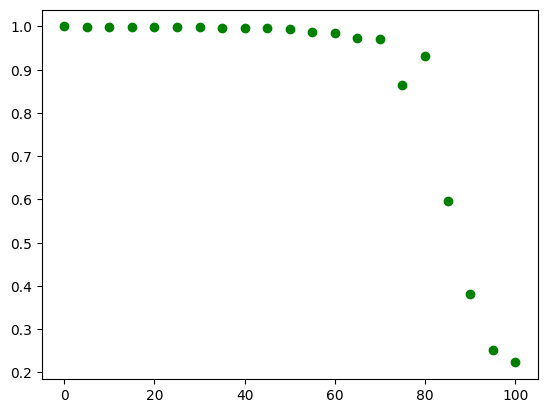

In [ ]:
#mathematica
    #run 1: 1659s = 27,7 min
#python
    #run 1: 2284s = 38,1 min

start = time() #Optional

noiseNetwork22 = randomNetwork([2,2], 0)
noisePlotlist22 = noisyDataTraining(noiseNetwork22[0], noiseNetwork22[1], noiseTrainingData.copy(), noiseNoisyData.copy(), 1, 0.1, 300, 100, 5)

print(time() - start) #Optional

plt.plot(noisePlotlist22[0], noisePlotlist22[1], 'go')
plt.show()

### Noisy data for a 2-3-2 network

Trained 300 rounds for a [2, 3, 2] network and 100 training pairs in 248.85 seconds
Trained 300 rounds for a [2, 3, 2] network and 100 training pairs in 250.4 seconds
Trained 300 rounds for a [2, 3, 2] network and 100 training pairs in 250.74 seconds
Trained 300 rounds for a [2, 3, 2] network and 100 training pairs in 249.36 seconds
Trained 300 rounds for a [2, 3, 2] network and 100 training pairs in 249.31 seconds
Trained 300 rounds for a [2, 3, 2] network and 100 training pairs in 251.16 seconds
Trained 300 rounds for a [2, 3, 2] network and 100 training pairs in 250.67 seconds
Trained 300 rounds for a [2, 3, 2] network and 100 training pairs in 250.9 seconds
Trained 300 rounds for a [2, 3, 2] network and 100 training pairs in 250.72 seconds
Trained 300 rounds for a [2, 3, 2] network and 100 training pairs in 249.88 seconds
Trained 300 rounds for a [2, 3, 2] network and 100 training pairs in 251.35 seconds
Trained 300 rounds for a [2, 3, 2] network and 100 training pairs in 250.6 sec

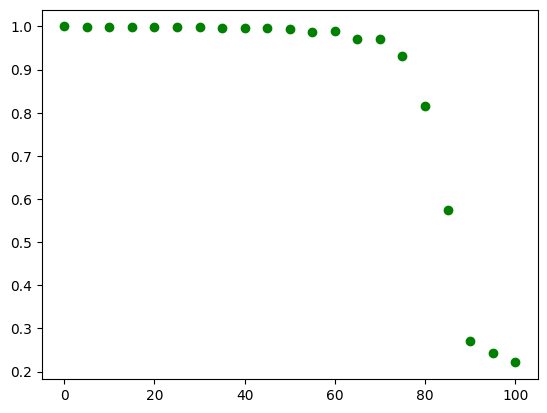

In [ ]:
#mathematica
    #run 1: 6256s = 104 min
#python
    #run 1: 7649s = 127 min

start = time() #Optional

noiseNetwork232 = randomNetwork([2,3,2], 0)
noisePlotlist232 = noisyDataTraining(noiseNetwork232[0], noiseNetwork232[1], noiseTrainingData.copy(), noiseNoisyData.copy(), 1, 0.1, 300, 100, 5)

print(time() - start) #Optional

plt.plot(noisePlotlist232[0], noisePlotlist232[1], 'go')
plt.show()

# 5. Temp Coding

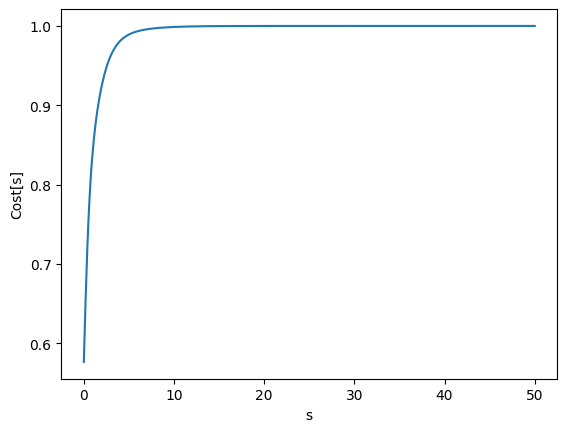

In [ ]:
network121f = randomNetwork([1,2,1], 10)
qnnArch = network121f[0]
networkUnitaries = network121f[1]
trainingData = network121f[2]
targetUnitary = network121f[3]

plotlist121, plotlist121_new = qnnTraining(network121f[0], network121f[1], network121f[2], 1, 0.1, 500)
#plotlist121_new = qnnTraining(network121[0], network121[1], network121[2], 1, 0.1, 500)[1]

for i in range(len(plotlist121[1])):
    if plotlist121[1][i] >= 0.95:
        print("Exceeds cost of 0.95 at training step "+str(i))
        break

plt.plot(plotlist121[0], plotlist121[1])
plt.xlabel("s")
plt.ylabel("Cost[s]")
plt.show()

# Fault injection helper function
def flip_bit_in_float(f, bit=0):
    """Flip a single bit in a 32-bit float."""
    i = unpack('<I', pack('<f', f))[0]
    i ^= 1 << bit
    return unpack('<f', pack('<I', i))[0]

# Inject fault into the (0,0) element of the first unitary in the first hidden layer
U = networkUnitaries[1][0].full()
print("Initial:")
print(U[0, 0])
faulty_real = flip_bit_in_float(U[0, 0].real, bit=31)
U[0, 0] = faulty_real + 1j * U[0, 0].imag
networkUnitaries[1][0] = qt.Qobj(U, dims=networkUnitaries[1][0].dims)

print("⚠️ Fault injected.")

#print("Final:")
#print(U[0, 0].real)
#print(networkUnitaries[1][0])


### Training a 2-3-2 network

In [ ]:
network232 = randomNetwork([2,3,2], 10)
plotlist232 = qnnTraining(network232[0], network232[1], network232[2], 1, 0.1, 500)[0]

for i in range(len(plotlist232[1])):
    if plotlist232[1][i] >= 0.95:
        print("Exceeds cost of 0.95 at training step "+str(i))
        break

plt.plot(plotlist232[0], plotlist232[1])
plt.xlabel("s")
plt.ylabel("Cost[s]")
plt.show()

### Varying $\lambda$ for a 2-2 network

Trained 200 rounds for a [2, 2] network and 10 training pairs in 4.64 seconds
Trained 200 rounds for a [2, 2] network and 10 training pairs in 4.52 seconds
Trained 200 rounds for a [2, 2] network and 10 training pairs in 5.94 seconds


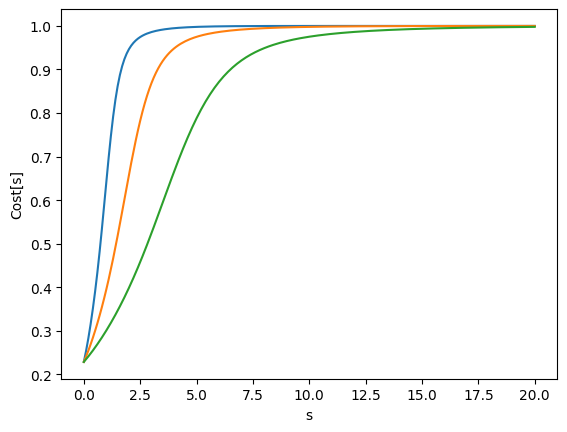

In [ ]:
network22 = randomNetwork([2,2], 10)

plotlistHalf = qnnTraining(network22[0], network22[1], network22[2], 0.5, 0.1, 200)[0]
plotlistOne = qnnTraining(network22[0], network22[1], network22[2], 1, 0.1, 200)[0]
plotlistTwo = qnnTraining(network22[0], network22[1], network22[2], 2, 0.1, 200)[0]


plt.plot(plotlistHalf[0],plotlistHalf[1])
plt.plot(plotlistOne[0], plotlistOne[1])
plt.plot(plotlistTwo[0], plotlistTwo[1])
plt.xlabel("s")
plt.ylabel("Cost[s]")
plt.show()